## Create Dataset

For the sake of demo, I will create a dataset using random generator. Here are the assumptions
- 10,000 applicants
- gender: equal chance for gender (Male, Female)
- income: normally distributed (mu = 45K, sd = 10K, prevent lower than \\$0)
- dependents: range from 0 to 5. wieghted as 5,5,4,3,2,1 correspondingly
- withholdings: whether company withheld taxes when giving payment. equal chance between (withheld, not withheld)
- filed_by: who filed tax? random choice among "Turbo Tax", "H&R Block", "Regional Accountants", and "Self" weighted 4,4,2,1 corresondingly
- electronic: whether tax return was filed electronically. randomly choose between electronically and by mail while wegithed 3 and 1 correspondingly

In [1]:
import pandas as pd
import numpy as np
import random# Create a mock dataset - Tax Refund
df_tax_refund = pd.DataFrame(
    {'gender': random.choices(["Male", "Female"], weights = [1, 1], k = 10000),
     'income': [max(0,int(i)) for i in np.random.normal(45000, 10000, 10000)],
     'dependents': random.choices([i for i in range(6)], weights = [5, 5, 4, 3, 2, 1], k = 10000),
     'withholdings': random.choices(["Withheld", "Not Withheld"], weights = [1, 1], k = 10000),
     'filed_by': random.choices(["Turbo Tax", "H&R Block", "Regional Accountants", "Self"], weights = [4, 4, 2, 1], k = 10000),
     'electronic': random.choices(["Electronically Filed", "Filed by Mail"], weights = [3, 1], k = 10000)
    })

df_tax_refund.head()

,gender,income,dependents,withholdings,filed_by,electronic
0,Female,36366,2,Withheld,Regional Accountants,Electronically Filed
1,Male,43757,0,Not Withheld,H&R Block,Electronically Filed
2,Female,33227,1,Withheld,Turbo Tax,Filed by Mail
3,Female,44450,5,Not Withheld,Turbo Tax,Filed by Mail
4,Female,39041,2,Not Withheld,H&R Block,Electronically Filed


Create an odd of getting tax refund correctly (Below are assumptions)
- Assumption #1: Default odds are 10 & Odds doesn't get changed by gender or income
- Assumption #2: odds of getting tax refund decreases slightly as number of dependents increase
- Assumption #3: odds of getting tax refund decreases if tax was not withheld before
- Assumption #4: odds of getting tax refund decreases when filed by regional accountants and even more when done by self
- Assumption #5 odds of getting tax refund decreases when filed by mail

In [2]:
def refund_calculator(row):
    """
    Description: compute odds then populate whether received or rejected based on the odds
        This function will be used within apply() function
    Input: row
    Output: binary value based on odds of receving expected refund
    """
    odds = 10 * 1/(1+0.3*row['dependents'])
    if row['withholdings'] != 'Withheld': odds = odds * 0.5
    if row['filed_by'] == 'Regional Accountants':
        odds = odds * 0.7
    elif row['filed_by'] == 'self':
        odds = odds * 0.3
    if row['electronic'] == 'Filed by Mail': odds = odds * 0.5
    prob = odds/(odds + 1)
    return random.choices(["Received", "Rejected"], weights = [prob, 1-prob], k = 1)[0]
df_tax_refund['refund'] = df_tax_refund.apply(refund_calculator, axis=1)
df_tax_refund.head()
# df_tax_refund.info()

,gender,income,dependents,withholdings,filed_by,electronic,refund
0,Female,36366,2,Withheld,Regional Accountants,Electronically Filed,Received
1,Male,43757,0,Not Withheld,H&R Block,Electronically Filed,Received
2,Female,33227,1,Withheld,Turbo Tax,Filed by Mail,Received
3,Female,44450,5,Not Withheld,Turbo Tax,Filed by Mail,Rejected
4,Female,39041,2,Not Withheld,H&R Block,Electronically Filed,Rejected


## Explanatory Data Analysis

In [3]:
# Verify all values are non-null
df_tax_refund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gender        10000 non-null  object
 1   income        10000 non-null  int64 
 2   dependents    10000 non-null  int64 
 3   withholdings  10000 non-null  object
 4   filed_by      10000 non-null  object
 5   electronic    10000 non-null  object
 6   refund        10000 non-null  object
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


<Axes: xlabel='refund', ylabel='count'>

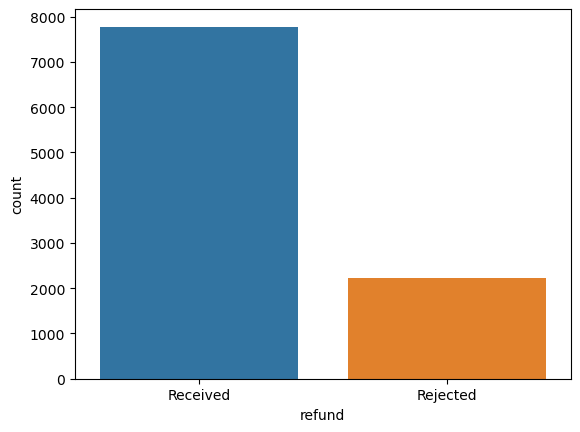

In [4]:
# Check whether generated data follows your expectation
import seaborn as sns
sns.countplot(data = df_tax_refund, x = 'refund')
# sns.countplot(df_tax_refund, x = 'gender', hue = 'refund')
# sns.countplot(df_tax_refund, x = 'withholdings', hue = 'refund')
# sns.countplot(df_tax_refund, x = 'filed_by', hue = 'refund')
# sns.displot(df_tax_refund, x="income", col="filed_by", stat="density")

## Random Forest

### Fit Model

In [5]:
# label encoding on categorical variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in [0,3,4,5,6]:
    df_tax_refund[df_tax_refund.columns[i]] = le.fit_transform(df_tax_refund[df_tax_refund.columns[i]])
    print(df_tax_refund.columns[i] + " converted:")
    print(list(le.classes_))
    print(le.transform(le.classes_))
# df_tax_refund.head()

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
features = df_tax_refund.iloc[:,:6]
labels = df_tax_refund.iloc[:,-1].tolist()
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.25, random_state = 12345)

gender converted:
['Female', 'Male']
[0 1]
withholdings converted:
['Not Withheld', 'Withheld']
[0 1]
filed_by converted:
['H&R Block', 'Regional Accountants', 'Self', 'Turbo Tax']
[0 1 2 3]
electronic converted:
['Electronically Filed', 'Filed by Mail']
[0 1]
refund converted:
['Received', 'Rejected']
[0 1]


In [6]:
# Fit a model
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(
    n_estimators = 100, # number of trees
    criterion = 'gini', # which threshold gives more information?
    max_depth = 5, # max depth of tree
    min_samples_split = 10, # There should be at least 10 people to get splitted
    class_weight = {0:1,1:4}, # Give more weight to finding 'Rejected people'
    verbose = 1, # Throw more outputs when fiting a model
    n_jobs = 4, # number of jobs to run in parallel
    bootstrap = True, # Bootstrap sampling is on
    oob_score = True, # Out-of-bag score
    ccp_alpha = 0.0, # Pruning by Penalizing if more terminal nodes (e.g. filed_by vs electronic)
    random_state=12345
)
clf_rf.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=5,
                       min_samples_split=10, n_jobs=4, oob_score=True,
                       random_state=12345, verbose=1)

### Evaluate Model

In [7]:
# Out of bag score (within training dataset): accuracy score is used as default
print(clf_rf.oob_score_)

0.5446666666666666


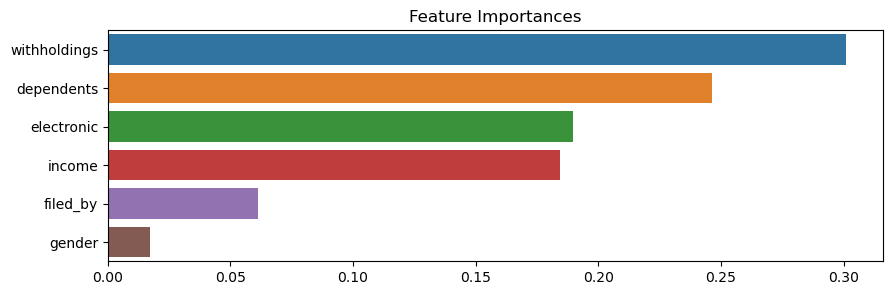

In [8]:
# Feature Importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.title('Feature Importances')
importance_order = np.argsort(-clf_rf.feature_importances_)
sns.barplot(x=clf_rf.feature_importances_[importance_order], y=clf_rf.feature_names_in_[importance_order])
plt.show()

Early thought: There shouldn't be much importance in "income" feature. filed_by should have more importance, but since tax done by "self" is unlikely than other options, the importance of the feature is less than what it should be.

#### Evaluate Model based on training dataset (Commented Out)

In [9]:
# # Predict using trained model on training dataset
# Y_train_pred = clf_rf.predict(X_train)
# # Revert 0 and 1 for Received & Rejected, so that Received would become 1 (positive)
# Y_train_rev = [(i+1)%2 for i in Y_train]
# Y_train_pred_rev = [(i+1)%2 for i in Y_train_pred]

# # Confusion Matrix on Training dataset
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, RocCurveDisplay
# cm_train = confusion_matrix(Y_train_rev, Y_train_pred_rev)
# sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='g',
#             xticklabels=['Rejected_pred','Received_pred'],yticklabels=['Rejected_actual','Received_actual'] )
# plt.show()

# # False positive is very costly (predicting getting refund but turned out to be no)
# # Thus, we need to give more weight to Precision.
# # If roughly equal number of positives and negatives, then use accuracy as well.

# # Precision: Among the ones that were predicted as Received, how many are actually getting Received?
# print("Precision-Received: " + str(cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])))
# print("--> Check score: " + str(precision_score(Y_train_rev, Y_train_pred_rev)))

# # # Recall: Among the actual reject, how many were correctly predicted as refund?
# # print("Recall-Rejected: " + str(cm_train[1,1]/(cm_train[1,1] + cm_train[1,0])))
# # recall_score(Y_train_rev, Y_train_pred_rev)

# # Recall on Rejected: Among the actual Rejected, how many were correctly predicted as Rejected?
# print("Recall-Rejected: " + str(cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])))

# # F1 score:
# print("F1 score: " + str(f1_score(Y_test_rev, Y_test_pred_rev)))

# # Accuracy score:
# print("Accuracy score: " + str((cm_train[0,0]+cm_train[1,1])/sum(sum(cm_train))))
# print("--> Check score: " + str(accuracy_score(Y_train_rev, Y_train_pred_rev)))

#### Evaluate Model based on testing dataset

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


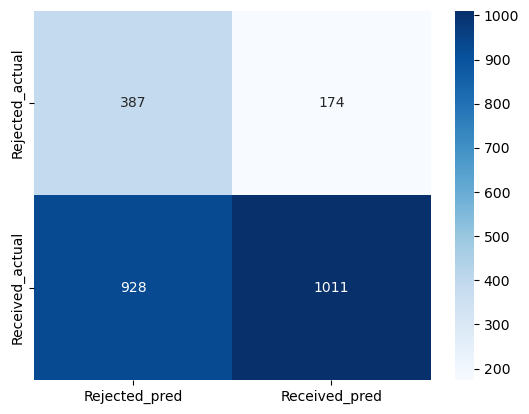

Precision-received: 0.8531645569620253
Recall-Rejected: 0.6898395721925134
F1 score: 0.6472471190781051
Accuracy score: 0.5592


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


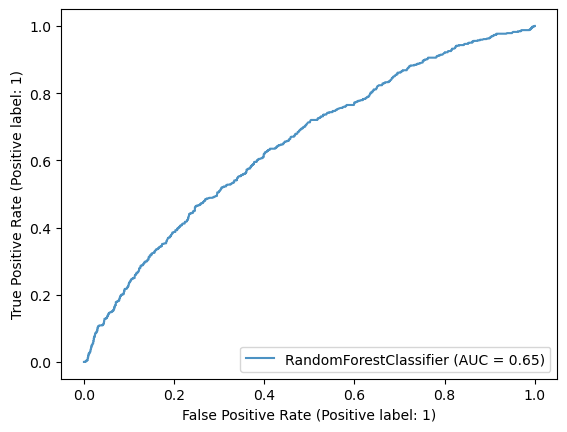

In [10]:
# Predict using trained model on test dataset
Y_test_pred = clf_rf.predict(X_test)
# Revert 0 and 1 for Received & Rejected, so that Received would become 1 (positive)
Y_test_rev = [(i+1)%2 for i in Y_test]
Y_test_pred_rev = [(i+1)%2 for i in Y_test_pred]

# Confusion Matrix on testing dataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, RocCurveDisplay, f1_score
cm_test = confusion_matrix(Y_test_rev, Y_test_pred_rev)
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Rejected_pred','Received_pred'],yticklabels=['Rejected_actual','Received_actual'] )
plt.show()

# False positive is very costly (predicting getting refund but turned out to be no)
# Thus, we need to give more weight to Precision.
# If roughly equal number of positives and negatives, then use accuracy as well.

# Precision: Among the ones that were predicted as Received, how many are actually getting Received?
print("Precision-received: " + str(cm_test[1,1]/(cm_test[0,1] + cm_test[1,1])))
# print("--> Check score: " + str(precision_score(Y_test_rev, Y_test_pred_rev)))

# # Recall: Among the actual received, how many were correctly received as refund?
# print("Recall-Received: " + str(cm_test[1,1]/(cm_test[1,1] + cm_test[1,0])))
# recall_score(Y_test_rev, Y_test_pred_rev)

# Recall on Rejected: Among the actual Rejected, how many were correctly predicted as Rejected?
print("Recall-Rejected: " + str(cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])))

# F1 score:
print("F1 score: " + str(f1_score(Y_test_rev, Y_test_pred_rev)))

# Accuracy score:
print("Accuracy score: " + str((cm_test[0,0]+cm_test[1,1])/sum(sum(cm_test))))
# print("--> Check score: " + str(accuracy_score(Y_test_rev, Y_test_pred_rev)))

# ROC:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(clf_rf, X_test, Y_test, ax=ax, alpha=0.8)
plt.show()

Takeaways:

- According to RF model, 20% of the people who were predicted have refund would get rejected by IRS which would be very costly.
- However, increasing weight on rejected might cause more samples to review, so we need to find a balance between improving precision score and costs associated with reviewing applicants' profile manually.
- Seems to be there is no overfitting when comparing training scores to test scores.
- Income has too much importance, whereas it should not be. More hyperparameter tuning is required (or potentially ommiting variable from training)

## XGBoost Classifier

### Fit Model

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
clf_xgb = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=1.0,
    max_depth=3,
    random_state=12345 # used when boostig sampling
)
# When fitting, give weight of 4 on rejected and 1 on received since they are unbalanced
clf_xgb.fit(X_train, Y_train, sample_weight = [3*i+1 for i in Y_train])

GradientBoostingClassifier(learning_rate=1.0, random_state=12345)

### Evaluate Model

In [12]:
# Review Requested: sklearn version is up to date... but why can't I access oob score?
import sklearn
print(sklearn.__version__)
# clf_xgb.oob_improvement_

1.3.0


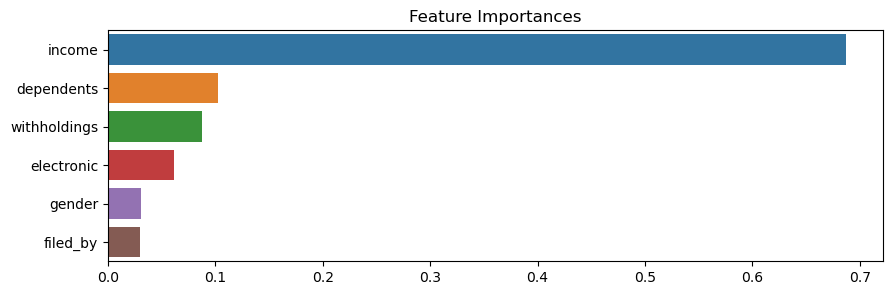

In [13]:
# Feature Importance
plt.figure(figsize=(10,3))
plt.title('Feature Importances')
importance_order = np.argsort(-clf_xgb.feature_importances_)
sns.barplot(x=clf_xgb.feature_importances_[importance_order], y=clf_xgb.feature_names_in_[importance_order])
plt.show()

Early thought: Again, there shouldn't be much importance in "income" feature, whereas "filed_by" should have more importance. Now I want to visualize the relationship between filed_by and income to see if whether there is correlation. If so, there might be a chance the income variable took credits of filed_by variable inappropriately.

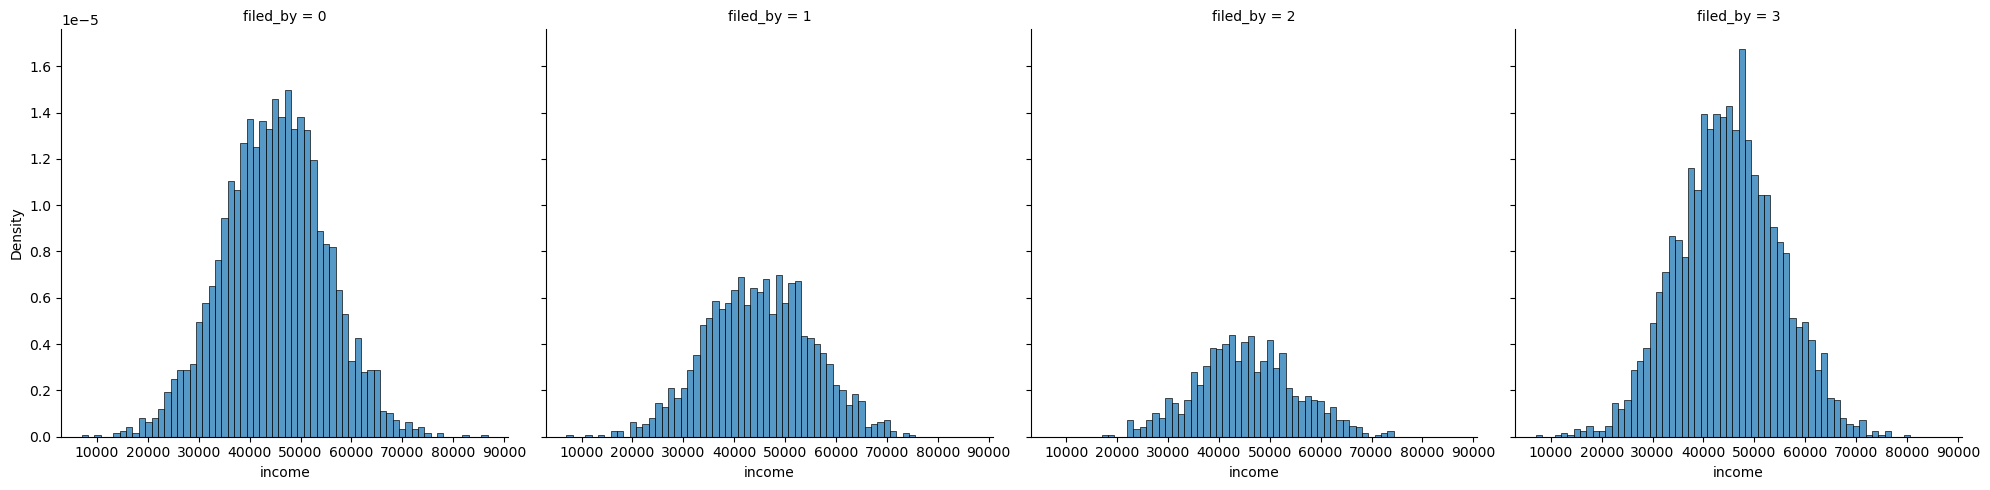

In [14]:
# sns.countplot(data = df_tax_refund, x = 'filed_by', hue = 'refund')
sns.displot(df_tax_refund, x="income", col="filed_by", stat="density")

Extended Early Thought: With breif EDA, seems like the income is distributed normally with similar mean and standard deviation no matter which filed_by group it belongs to. So it is less likely that income variable took the credit of filed_by variable's predictory power

#### Evaluate Model based on training dataset (Commented Out)

In [15]:
# # Predict using trained model on training dataset
# Y_train_pred = clf_xgb.predict(X_train)
# # Revert 0 and 1 for Received & Rejected, so that Received would become 1 (positive)
# Y_train_rev = [(i+1)%2 for i in Y_train]
# Y_train_pred_rev = [(i+1)%2 for i in Y_train_pred]

# # Confusion Matrix on Training dataset
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
# cm_train = confusion_matrix(Y_train_rev, Y_train_pred_rev)
# sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='g',
#             xticklabels=['Rejected_pred','Received_pred'],yticklabels=['Rejected_actual','Received_actual'] )
# plt.show()

# # False positive is very costly (predicting getting refund but turned out to be no)
# # Thus, we need to give more weight to Precision.
# # If roughly equal number of positives and negatives, then use accuracy as well.

# # Precision: Among the ones that were predicted as Received, how many are actually getting Received?
# print("Precision-Received: " + str(cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])))
# print("--> Check score: " + str(precision_score(Y_train_rev, Y_train_pred_rev)))

# # # Recall: Among the actual refund, how many were correctly predicted as refund?
# # print("Recall-Received: " + str(cm_train[1,1]/(cm_train[1,1] + cm_train[1,0])))
# # recall_score(Y_train_rev, Y_train_pred_rev)

# # Recall on Rejected: Among the actual Rejected, how many were correctly predicted as Rejected?
# print("Recall-rejected: " + str(cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])))

# # F1 score:
# print("F1 score: " + str(f1_score(Y_test_rev, Y_test_pred_rev)))

# # Accuracy score:
# print("Accuracy score: " + str((cm_train[0,0]+cm_train[1,1])/sum(sum(cm_train))))
# print("--> Check score: " + str(accuracy_score(Y_train_rev, Y_train_pred_rev)))

#### Evaluate Model based on testing dataset

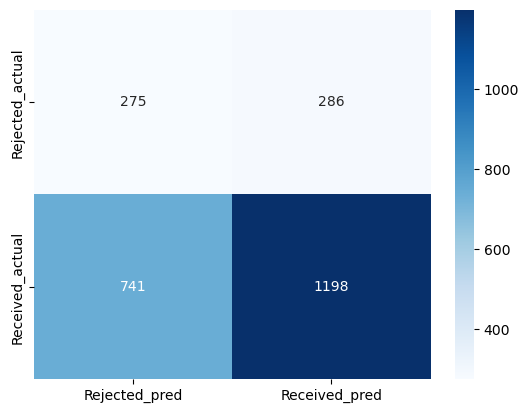

Precision-Received: 0.807277628032345
--> Check score: 0.807277628032345
Recall-Rejected: 0.49019607843137253
F1 score: 0.6999707858603564
Accuracy score: 0.5892
--> Check score: 0.5892


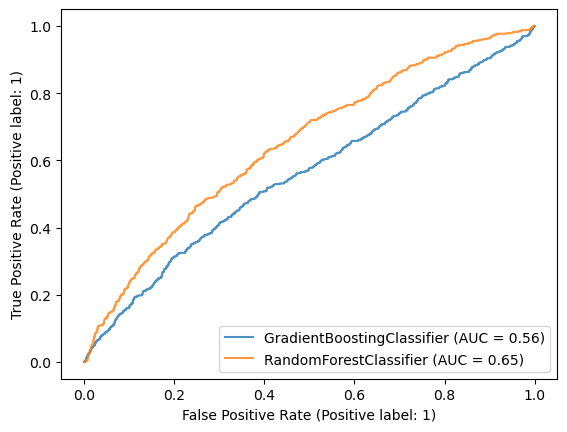

In [16]:
# Predict using trained model on test dataset
Y_test_pred = clf_xgb.predict(X_test)
# Revert 0 and 1 for Received & Rejected, so that Received would become 1 (positive)
Y_test_rev = [(i+1)%2 for i in Y_test]
Y_test_pred_rev = [(i+1)%2 for i in Y_test_pred]

# Confusion Matrix on testing dataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
cm_test = confusion_matrix(Y_test_rev, Y_test_pred_rev)
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Rejected_pred','Received_pred'],yticklabels=['Rejected_actual','Received_actual'] )
plt.show()

# False positive is very costly (predicting getting refund but turned out to be no)
# Thus, we need to give more weight to Precision.
# If roughly equal number of positives and negatives, then use accuracy as well.

# Precision: Among the ones that were predicted as Received, how many are actually getting Received?
print("Precision-Received: " + str(cm_test[1,1]/(cm_test[0,1] + cm_test[1,1])))
print("--> Check score: " + str(precision_score(Y_test_rev, Y_test_pred_rev)))

# # Recall: Among the actual refund, how many were correctly predicted as refund?
# print("Recall-Received: " + str(cm_test[1,1]/(cm_test[1,1] + cm_test[1,0])))
# recall_score(Y_test_rev, Y_test_pred_rev)

# Recall on Rejected: Among the actual Rejected, how many were correctly predicted as Rejected?
print("Recall-Rejected: " + str(cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])))

# F1 score:
print("F1 score: " + str(f1_score(Y_test_rev, Y_test_pred_rev)))

# Accuracy score:
print("Accuracy score: " + str((cm_test[0,0]+cm_test[1,1])/sum(sum(cm_test))))
print("--> Check score: " + str(accuracy_score(Y_test_rev, Y_test_pred_rev)))

# ROC:
ax = plt.gca()
xbgc_disp = RocCurveDisplay.from_estimator(clf_xgb, X_test, Y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## Refitting after binning income variable

#### Binning Income
After building model, income has more importance because it's a continuous variable and has a chance to be splitted in greater detail than the other variables.

In [17]:
def income_binner(row):
    """
    Description: bin income into categorical groups
    Input: row
    Output: bin value based on income value
    """
    if row['income'] >= 60000:
        income_bin = "60K+"
    elif row['income'] >= 45000:
        income_bin = "45~60K"
    elif row['income'] >= 30000:
        income_bin = "30~45K"
    else:
        income_bin = "30K-"
    return income_bin
df_tax_refund['income'] = df_tax_refund.apply(income_binner, axis=1)
df_tax_refund.head()

,gender,income,dependents,withholdings,filed_by,electronic,refund
0,0,30~45K,2,1,1,0,0
1,1,30~45K,0,0,0,0,0
2,0,30~45K,1,1,3,1,0
3,0,30~45K,5,0,3,1,1
4,0,30~45K,2,0,0,0,1


#### fitting models again

In [18]:
# label encoding on categorical variables
df_tax_refund['income'] = le.fit_transform(df_tax_refund['income'])
print("income converted:")
print(list(le.classes_))
print(le.transform(le.classes_))

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
features = df_tax_refund.iloc[:,:6]
labels = df_tax_refund.iloc[:,-1].tolist()
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.25, random_state = 12345)

income converted:
['30K-', '30~45K', '45~60K', '60K+']
[0 1 2 3]


In [19]:
# Random Forest
clf_rf = RandomForestClassifier(
    n_estimators = 100, # number of trees
    criterion = 'gini', # which threshold gives more information?
    max_depth = 5, # max depth of tree
    min_samples_split = 10, # There should be at least 10 people to get splitted
    class_weight = {0:1,1:4}, # Give more weight to finding 'Rejected people'
    verbose = 1, # Throw more outputs when fiting a model
    n_jobs = 4, # number of jobs to run in parallel
    bootstrap = True, # Bootstrap sampling is on
    oob_score = True, # Out-of-bag score
    ccp_alpha = 0.0, # Pruning by Penalizing if more terminal nodes (e.g. filed_by vs electronic)
    random_state=12345
)
clf_rf.fit(X_train, Y_train)

# XGB Classifier
clf_xgb = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=1.0,
    max_depth=3,
    random_state=12345 # used when boostig sampling
)
# When fitting, give weight of 4 on rejected and 1 on received since they are unbalanced
clf_xgb.fit(X_train, Y_train, sample_weight = [3*i+1 for i in Y_train])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


GradientBoostingClassifier(learning_rate=1.0, random_state=12345)

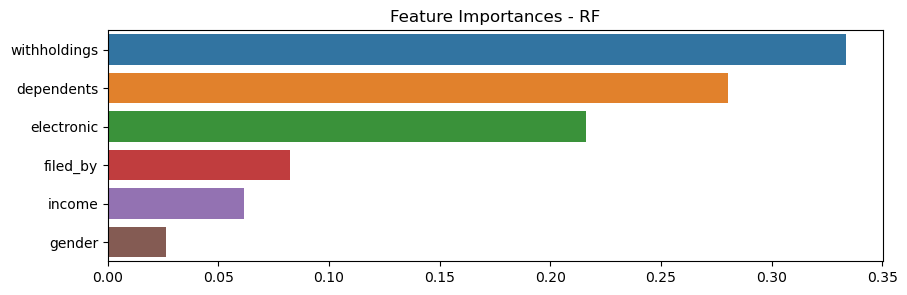

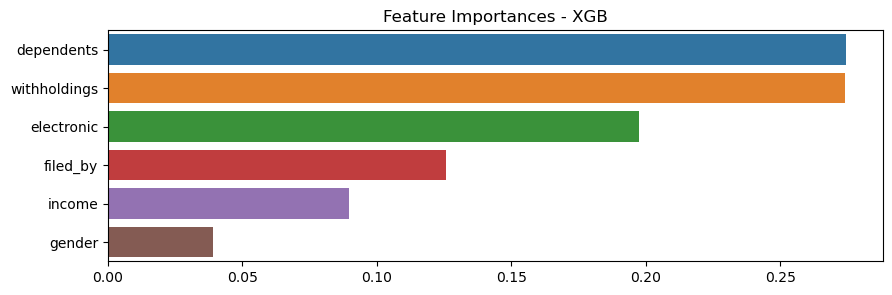

In [20]:
# Feature Importance
plt.figure(figsize=(10,3))
plt.title('Feature Importances - RF')
importance_order = np.argsort(-clf_rf.feature_importances_)
sns.barplot(x=clf_rf.feature_importances_[importance_order], y=clf_rf.feature_names_in_[importance_order])
plt.show()

plt.figure(figsize=(10,3))
plt.title('Feature Importances - XGB')
importance_order = np.argsort(-clf_xgb.feature_importances_)
sns.barplot(x=clf_xgb.feature_importances_[importance_order], y=clf_xgb.feature_names_in_[importance_order])
plt.show()

Now Income variable has much less feature importance when compared to the prior one before binning. This looks more reasonable. As a next step, skip evaluation based on training but jump to the test dataset.

#### Evaluation based on test datasets

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


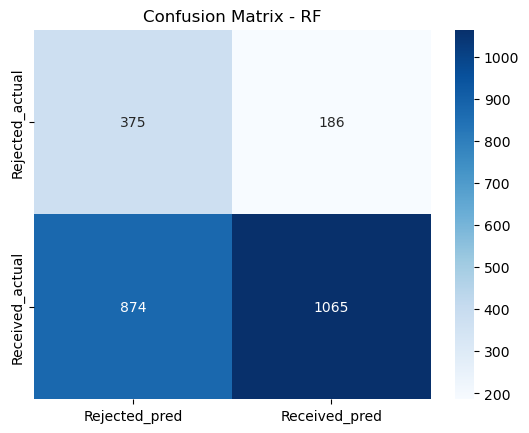

RF - Scores:
Precision-Received: 0.8513189448441247
F1 score: 0.6677115987460814
Recall-Rejected: 0.6684491978609626
Accuracy score: 0.576


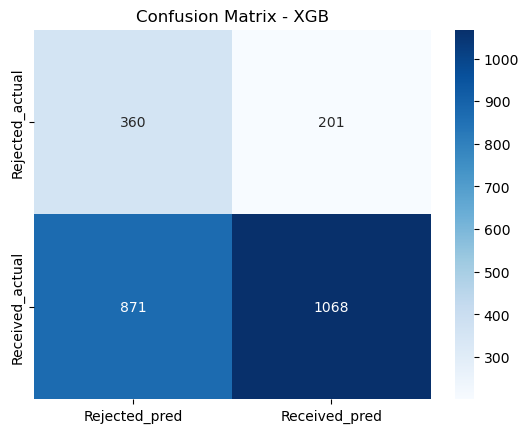

XGB - Scores:
Precision-Received: 0.8416075650118203
Recall-Rejected: 0.6417112299465241
F1 score: 0.6658354114713217
Accuracy score: 0.5712


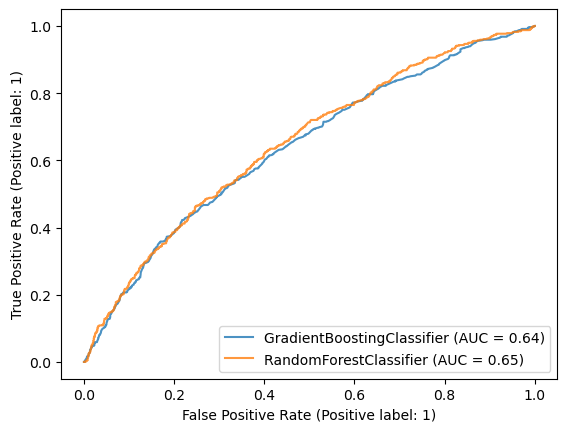

In [21]:
#####################################################
# Random Forest
# Predict using trained model on test dataset
Y_test_pred = clf_rf.predict(X_test)
# Revert 0 and 1 for Received & Rejected, so that Received would become 1 (positive)
Y_test_rev = [(i+1)%2 for i in Y_test]
Y_test_pred_rev = [(i+1)%2 for i in Y_test_pred]

# Confusion Matrix on testing dataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
cm_test = confusion_matrix(Y_test_rev, Y_test_pred_rev)
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Rejected_pred','Received_pred'],yticklabels=['Rejected_actual','Received_actual'] )
plt.title("Confusion Matrix - RF")
plt.show()

# False positive is very costly (predicting getting refund but turned out to be no)
# Thus, we need to give more weight to Precision.
# If roughly equal number of positives and negatives, then use accuracy as well.
print("RF - Scores:")
# Precision: Among the ones that were predicted as Received, how many are actually getting Received?
print("Precision-Received: " + str(cm_test[1,1]/(cm_test[0,1] + cm_test[1,1])))

# # Recall: Among the actual refund, how many were correctly predicted as refund?
# print("Recall-Received: " + str(cm_test[1,1]/(cm_test[1,1] + cm_test[1,0])))

# Recall on Rejected: Among the actual Rejected, how many were correctly predicted as Rejected?

# F1 score:
print("F1 score: " + str(f1_score(Y_test_rev, Y_test_pred_rev)))
print("Recall-Rejected: " + str(cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])))

# Accuracy score:
print("Accuracy score: " + str((cm_test[0,0]+cm_test[1,1])/sum(sum(cm_test))))

#####################################################
# XGBoost Classifier
# Predict using tested model on test dataset
Y_test_pred = clf_xgb.predict(X_test)
# Revert 0 and 1 for Received & Rejected, so that Received would become 1 (positive)
Y_test_rev = [(i+1)%2 for i in Y_test]
Y_test_pred_rev = [(i+1)%2 for i in Y_test_pred]

# Confusion Matrix on testing dataset
cm_test = confusion_matrix(Y_test_rev, Y_test_pred_rev)
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Rejected_pred','Received_pred'],yticklabels=['Rejected_actual','Received_actual'])
plt.title("Confusion Matrix - XGB")
plt.show()

print("XGB - Scores:")
# Precision: Among the ones that were predicted as Received, how many are actually getting Received?
print("Precision-Received: " + str(cm_test[1,1]/(cm_test[0,1] + cm_test[1,1])))

# # Recall: Among the actual refund, how many were correctly predicted as refund?
# print("Recall-Received: " + str(cm_test[1,1]/(cm_test[1,1] + cm_test[1,0])))

# Recall on Rejected: Among the actual Rejected, how many were correctly predicted as Rejected?
print("Recall-Rejected: " + str(cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])))

# F1 score:
print("F1 score: " + str(f1_score(Y_test_rev, Y_test_pred_rev)))

# Accuracy score:
print("Accuracy score: " + str((cm_test[0,0]+cm_test[1,1])/sum(sum(cm_test))))

# ROC:
ax = plt.gca()
xbgc_disp = RocCurveDisplay.from_estimator(clf_xgb, X_test, Y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()

Takeaways:
- precision score got improved in xgboost model after binning income variable
- precision score got improved in xgboost model after binning income variable
- If you classify everything as Received, precision score would be slgihtly less than 0.8, while both models' precision scores are around 0.85. There is a room for improvement.
- AUC didn't improve much on RF model but improved in XGB model after binning income
- Income now has reasonably low importance
- More hyperparameter tuning is required
- AUC is slightly more than 0.65 meaning randomly chosen "received" would be ranked higher than randomly chosen "rejected" with 65% chance. Since AUC is somewhat close to 0.5, both models doesn't have a good discrimination power. (0.8~0.9 is considered to be acceptable)

Areas of improvements:
- Need more development in the model using hyperparameter tuning & cross validation.
- Once reliable model is developed, providing early tax return service would be less costly by providing only to the people who got approved by the developed model.

## Conclusion: So What?

Recommendation to Executives:
- Let's suppose admin & legal costs associated with taking the tax refund back are \\$50
- Let's also suppose the expected increase in the lifetime value of each approved customer is \\$30
- Using the current & underdeveloped Random Forest model, 68.8% of the ones who would get rejected are being screened out. However, people who could've enrolled will be screened out.
- Approximately, we can save \\$50 * 386 / 100 = \\$193 for every 100 customers applying to this project. But This also means, \\$87.5 of admin & legal costs would occur for every 100 applicants.
- Number of expected approved customers is 1,163 / 100 = 11.63. Additional lifetime value from approved customers is \\$30 * 11.63 = \\$348.9 for every 100 applicants
- Since the expected increase of lifetime value is greater than admin & legal costs, I would recommend launching this project while data time keeps improving the machine learning model.
